## FD b2 ANN Fitting

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)

Mounted at /content/drive


In [2]:
target = 'b2'

In [3]:
import pandas as pd
import glob
import os
import numpy as np
import sys
import pickle
from tqdm import tqdm
! pip install pmcx
from concurrent.futures import ThreadPoolExecutor
#from FDNIRS_dprocesser import load_and_process_all as lapa
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.6 MB/s eta 0:00:00


### Read the saved CSV

In [4]:
import pandas as pd
import glob
import numpy as np
import sys
! pip install pmcx
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/MCX_data'
sys.path.append(folder_path)
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
csv_path = '/content/drive/MyDrive/MCX_data/stage2_train.csv'
final_array = np.loadtxt(csv_path, delimiter=',')
print(final_array.shape)
X_train = final_array
#
csv_path_test = '/content/drive/MyDrive/MCX_data/stage2_test.csv'
final_array = np.loadtxt(csv_path_test, delimiter=',')
print(final_array.shape)
X_test = final_array

(10000, 192)
(1000, 192)


### GT

In [6]:
GT_folder_train = '/content/drive/MyDrive/MCX_data/stage2_csv/'
GT_folder_test = '/content/drive/MyDrive/MCX_data/test_csv/'

In [7]:
csv_files_train = glob.glob(os.path.join(GT_folder_train, '*.csv'))
GT_all_train = pd.concat([pd.read_csv(f) for f in csv_files_train], ignore_index=True)
csv_files_test = glob.glob(os.path.join(GT_folder_test, '*.csv'))
GT_all_test = pd.concat([pd.read_csv(f) for f in csv_files_test], ignore_index=True)

In [8]:
sorted_ids = [i+1 for i in range(10000)]
# Ensure ID column is integer
GT_all_train['ID'] = GT_all_train['ID'].astype(int)

# Filter and sort GT_all to match the sorted_ids order
GT_filtered = GT_all_train[GT_all_train['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()

# Extract HHB2 as Y
Y = GT_filtered[target].values
y_train = Y.reshape(-1, 1)

In [9]:
sorted_ids = [i+1 for i in range(1000)]
# Ensure ID column is integer
GT_all_test['ID'] = GT_all_test['ID'].astype(int)

# Filter and sort GT_all to match the sorted_ids order
GT_filtered = GT_all_test[GT_all_test['ID'].isin(sorted_ids)].copy()
GT_filtered = GT_filtered.set_index('ID').loc[sorted_ids].reset_index()

# Extract HHB2 as Y
Y = GT_filtered[target].values
y_test = Y.reshape(-1, 1)

In [10]:
# fit only on training data
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

# apply (same μ,σ) everywhere
X_train = scaler_X.transform(X_train)
X_test  = scaler_X.transform(X_test)
Y_train = scaler_y.transform(y_train)
Y_test = scaler_y.transform(y_test)

In [11]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(10000, 192) (1000, 192) (10000, 1) (1000, 1)


### ANN

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import Huber
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
import joblib, tensorflow as tf
WEIGHT_DIR = Path("/content/drive/MyDrive/MCX_data/weights")

model = Sequential([
    Input(shape=(192,)),
    Dense(1000, activation='relu'),
    Dropout(0.1),

    Dense(4096, activation='relu'),
    Dropout(0.1),

    Dense(4096, activation='relu'),
    Dropout(0.2),

    Dense(8192, activation='relu'),
    Dropout(0.2),

    Dense(8192*2, activation='relu'),
    Dropout(0.2),

    Dense(8192, activation='relu'),
    Dropout(0.2),

    Dense(4096, activation='relu'),
    Dropout(0.2),

    Dense(2048, activation='relu'),
    Dropout(0.2),

    Dense(1024, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(256, activation='relu'),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(32, activation='relu'),
    Dropout(0.0),

    Dense(1)  # Output layer for regression
])


# 1) Create a checkpoint callback that saves the best model:
checkpoint_cb = ModelCheckpoint(
    f"FD_{target}_ANN.keras",        # filepath to save to
    monitor="val_loss",     # quantity to monitor
    mode="min",             # we want to minimize val_loss
    save_best_only=True,    # only save when val_loss decreases
    save_weights_only=False # set True if you only want weights
)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss="mse")

# 3) Fit with the checkpoint callback
history = model.fit(
    X_train, Y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint_cb]
)

# 4) Later on (or in a new script), load the best model:
model = tf.keras.models.load_model(f"FD_{target}_ANN.keras")

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 68s 203ms/step - loss: 0.9015 - val_loss: 0.6706
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - loss: 0.6894 - val_loss: 0.5893
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - loss: 0.5858 - val_loss: 0.5483
Epoch 4/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - loss: 0.5469 - val_loss: 0.4852
Epoch 5/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.5271 - val_loss: 0.5364
Epoch 6/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - loss: 0.5423 - val_loss: 0.4665
Epoch 7/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - loss: 0.4897 - val_loss: 0.4609
Epoch 8/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - loss: 0.4514 - val_loss: 0.4254
Epoch 9/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - loss: 0.4170 - val_loss: 0.4004
Epoch 10/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - loss: 0.4188 - val_loss: 0.3660
Epoch 11/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3959 - val_loss: 0.3882
Epoch 12/200
282/282

In [13]:
from pathlib import Path
import joblib, tensorflow as tf

WEIGHT_DIR = Path("/content/drive/MyDrive/MCX_data/weights")
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

model_path = WEIGHT_DIR / f"FD_{target}_ANN.keras"
model.save(model_path)

joblib.dump(scaler_X, WEIGHT_DIR / f"X_FD_{target}_ANN.pkl")
joblib.dump(scaler_y, WEIGHT_DIR / f"Y_FD_{target}_ANN.pkl")

print("model file exists:", model_path.exists(),
      "size =", model_path.stat().st_size/1e6, "MB")

model file exists: True size = 4413.937482 MB


In [14]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, scaler_y.transform(np.array([[0.3]]))[0][0], scaler_y.transform(np.array([[3.3]]))[0][0])
mse = mean_squared_error(Y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
Test MSE: 0.0982


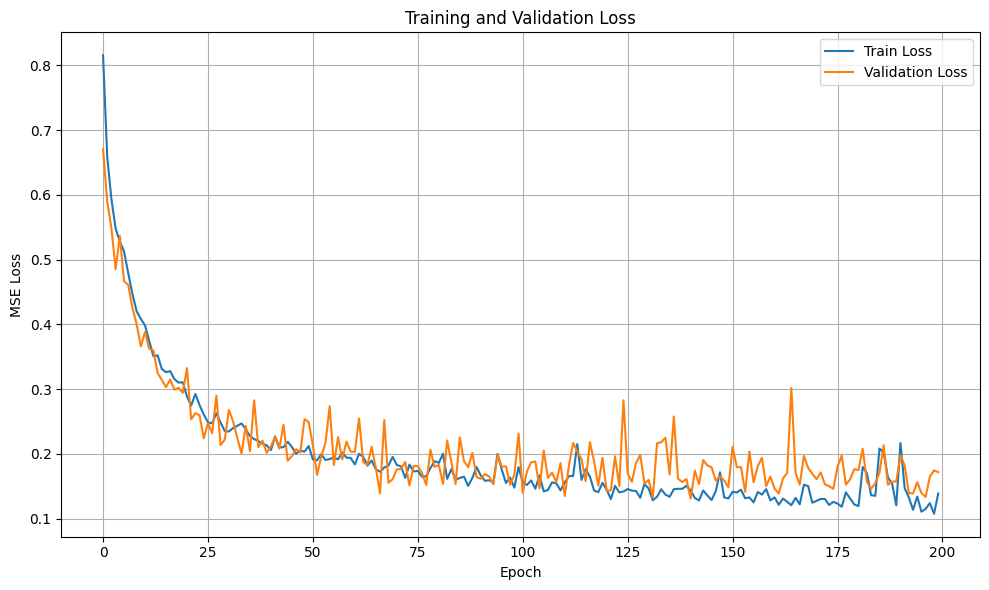

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Test MSE: 0.0736


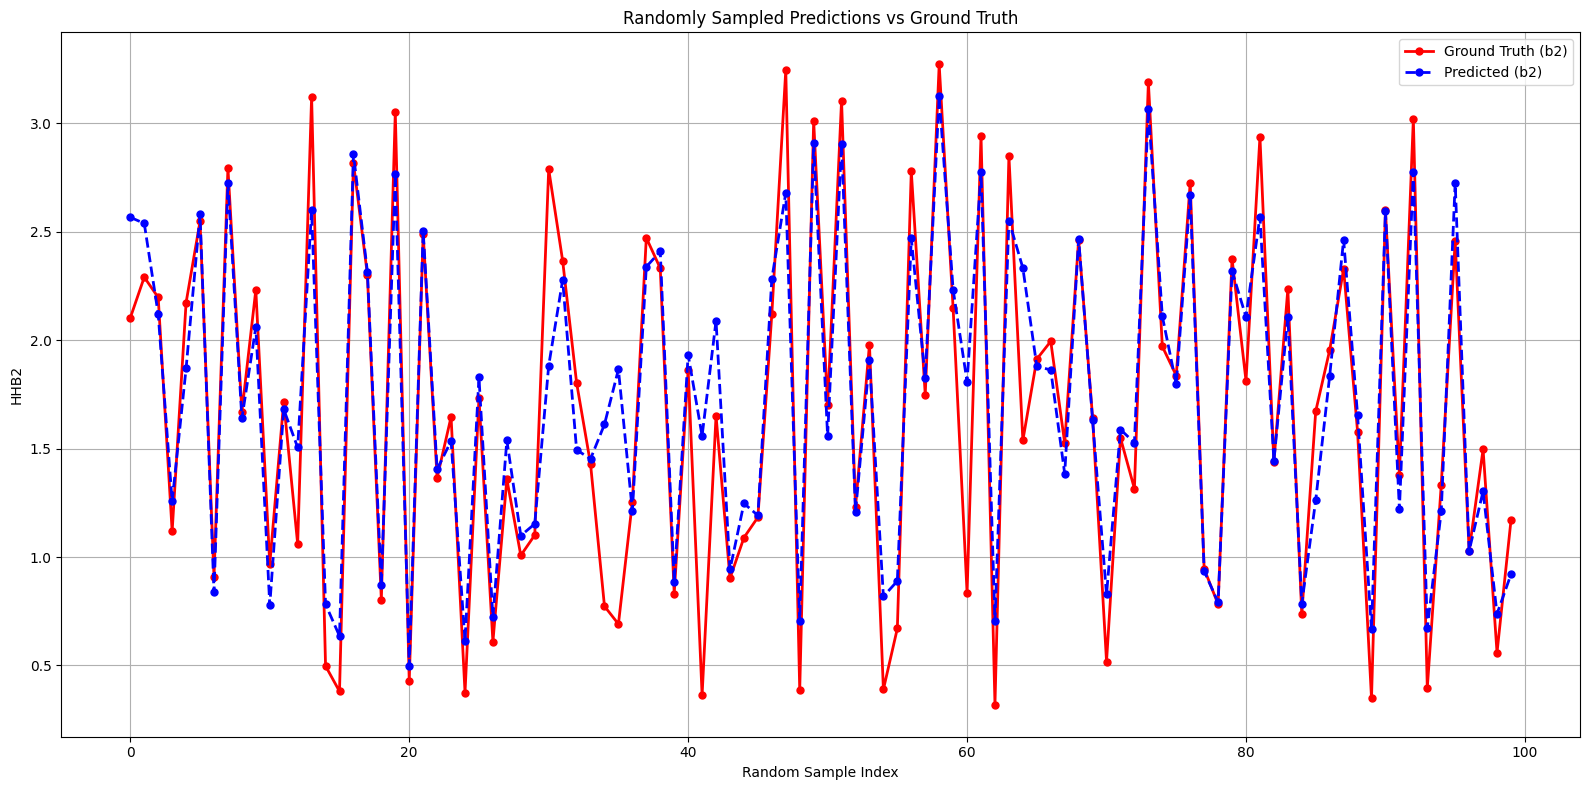

In [16]:
# Randomly select 100 indices
import matplotlib.pyplot as plt
indices = np.random.choice(len(Y_test), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Test MSE: {mse:.4f}")


# Extract corresponding values
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label=f'Ground Truth ({target})', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label=f'Predicted ({target})', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('HHB2')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# assume y_pred_rescaled and y_test_rescaled are your arrays
y_pred = np.asarray(y_pred_rescaled).ravel()
y_true = np.asarray(y_test_rescaled).ravel()

# residuals
residuals = y_pred - y_true

# 1) MAE (μm)
mae = mean_absolute_error(y_true, y_pred)

# 2) MARE (%)
mare = np.mean(np.abs(residuals) / np.abs(y_true)) * 100

# 3) RMSE (μm)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 4) R²
r2 = r2_score(y_true, y_pred)

# 5) Bias ± SD (μm)
bias = np.mean(residuals)
sd   = np.std(residuals, ddof=1)   # sample standard deviation

# print results
print(f"MAE (μm):          {mae:.4f}")
print(f"MARE (%):          {mare:.4f}")
print(f"RMSE (μm):         {rmse:.4f}")
print(f"R²:                {r2:.4f}")
print(f"Bias ± SD (μm):    {bias:.4f} ± {sd:.4f}")


MAE (μm):          0.1897
MARE (%):          16.7133
RMSE (μm):         0.2713
R²:                0.9018
Bias ± SD (μm):    0.0049 ± 0.2714


Test MSE (original scale): 0.0736


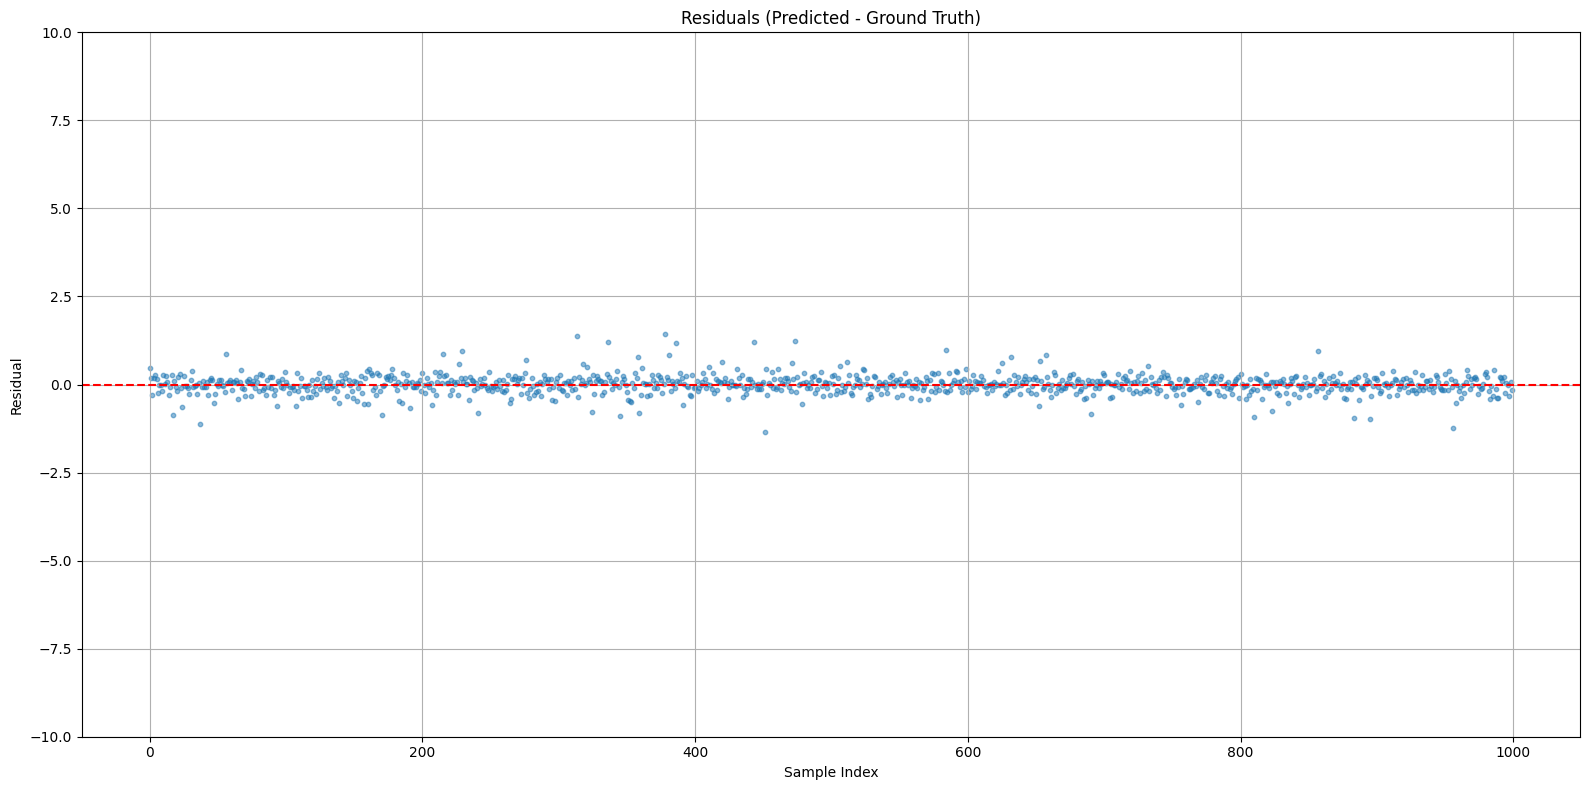

In [18]:
# Compute residuals in original scale
residuals = y_pred_rescaled - y_test_rescaled

mse_rescaled = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")

# Plot residuals
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.ylim(-10, 10)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

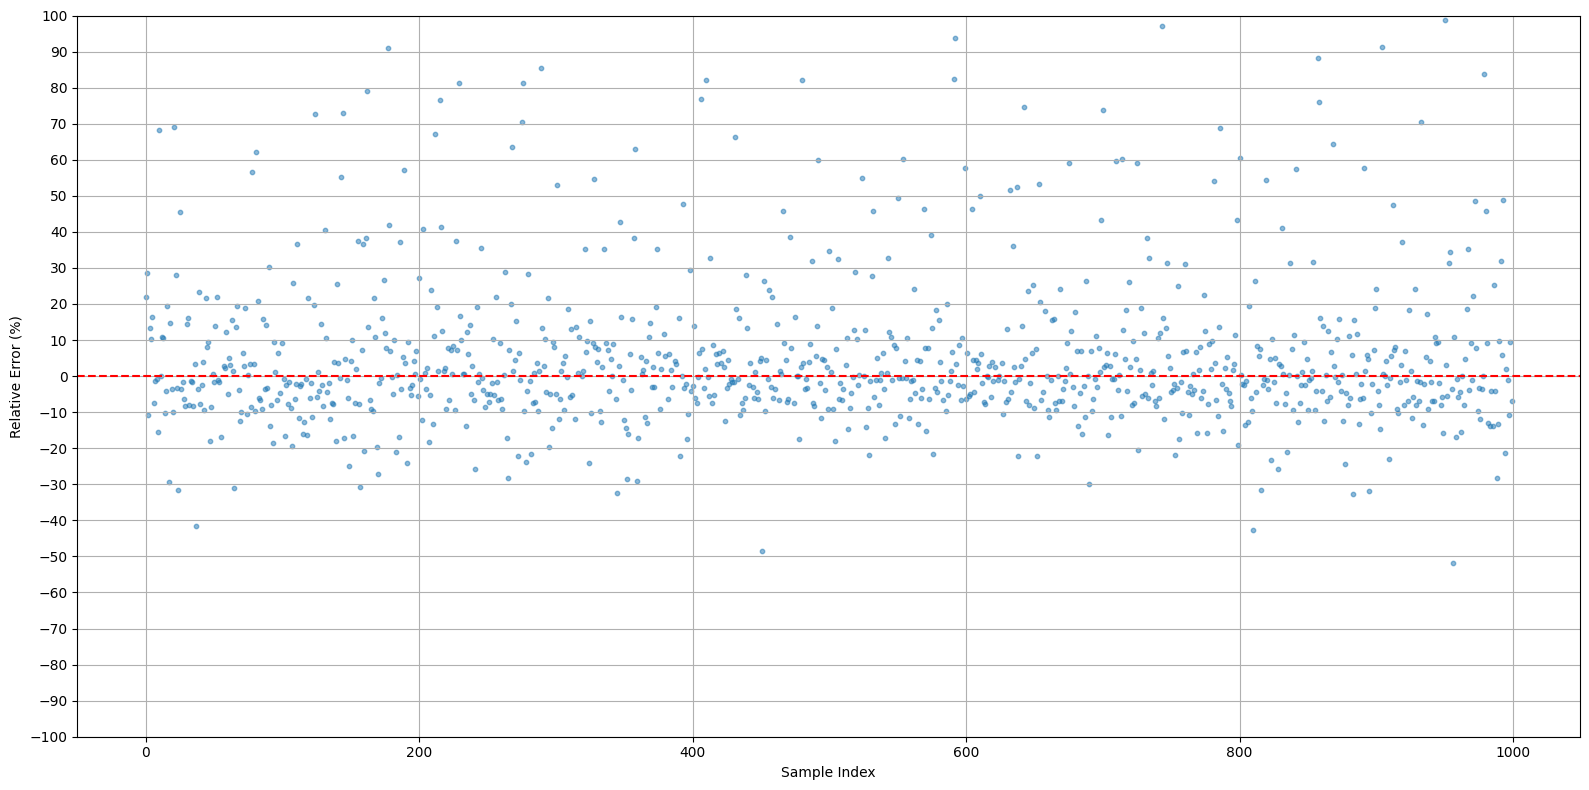

In [19]:
# Compute relative error (percentage)
relative_error = ((y_pred_rescaled - y_test_rescaled) / y_test_rescaled) * 100

# Plot relative error
plt.figure(figsize=(16, 8))
plt.scatter(range(len(relative_error)), relative_error, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.ylabel("Relative Error (%)")
plt.ylim(-100, 100)
plt.yticks(np.arange(-100, 101, 10))
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()


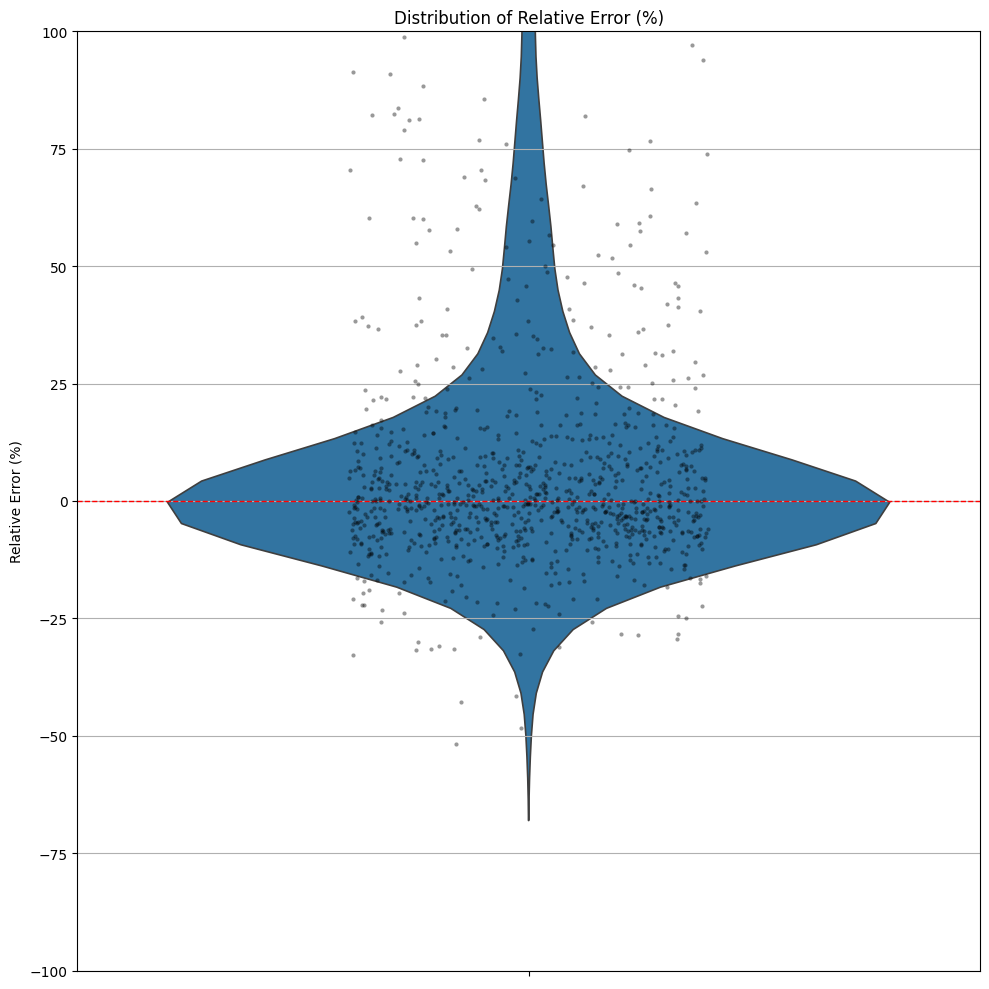

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare DataFrame for seaborn
df_plot = pd.DataFrame({
    'Relative Error (%)': relative_error.flatten()
})

plt.figure(figsize=(10, 10))
sns.violinplot(data=df_plot, y='Relative Error (%)', inner=None, linewidth=1.2)
sns.stripplot(data=df_plot, y='Relative Error (%)', color='black', alpha=0.4, jitter=0.2, size=3)

plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.ylim(-100, 100)
plt.title('Distribution of Relative Error (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


R² = 0.9018235369536912
MAPE = 16.713322669789274 %


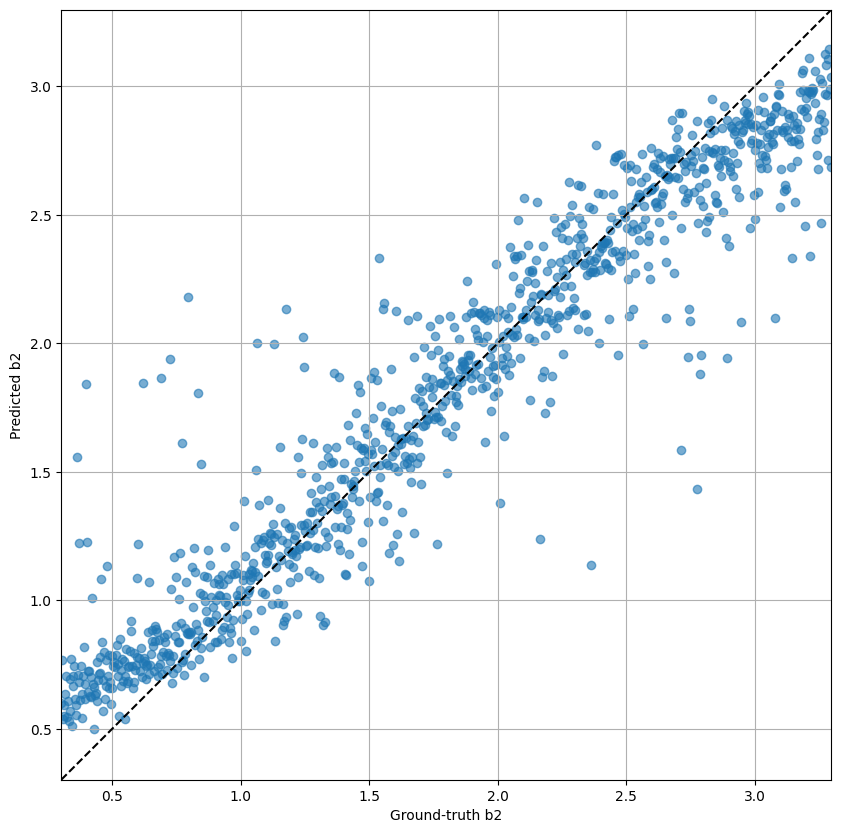

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_percentage_error

plt.figure(figsize=(10,10))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6)
lims = [min(y_test_rescaled.min(), y_pred_rescaled.min()),
        max(y_test_rescaled.max(), y_pred_rescaled.max())]
plt.plot(lims, lims, 'k--')              # identity line
plt.xlabel(f'Ground-truth {target}'); plt.ylabel(f'Predicted {target}')
plt.axis('square'); plt.xlim(lims); plt.ylim(lims)
plt.grid()
print("R² =", r2_score(y_test_rescaled, y_pred_rescaled))
print("MAPE =", mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)*100, "%")
plt.show()

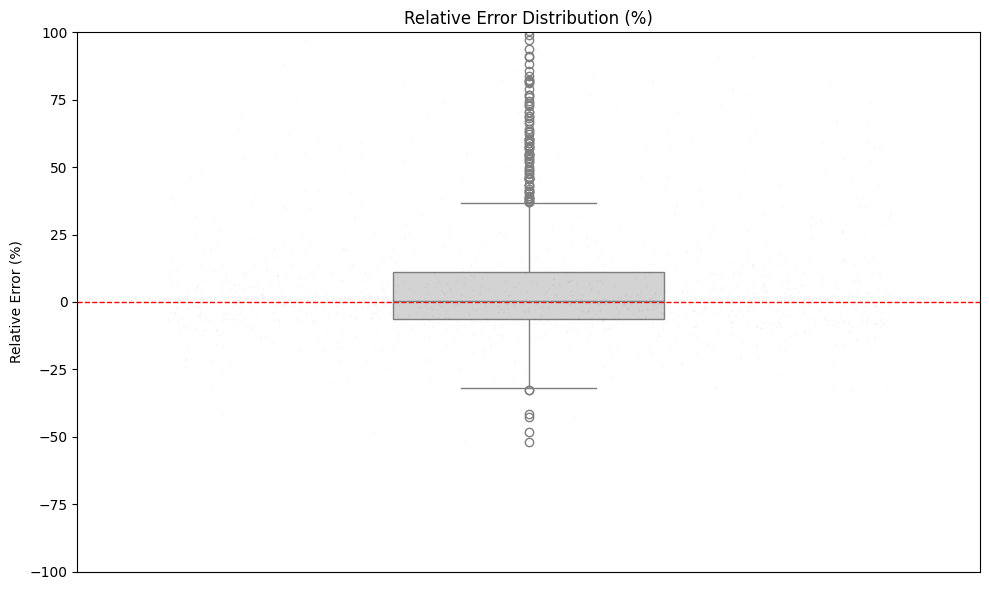

In [22]:
relative_error = relative_error.squeeze()

plt.figure(figsize=(10, 6))
sns.boxplot(y=relative_error, color='lightgray', width=0.3)
sns.stripplot(y=relative_error, color='black', alpha=0.03, jitter=0.4, size=1.5)

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Relative Error Distribution (%)')
plt.ylabel('Relative Error (%)')
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


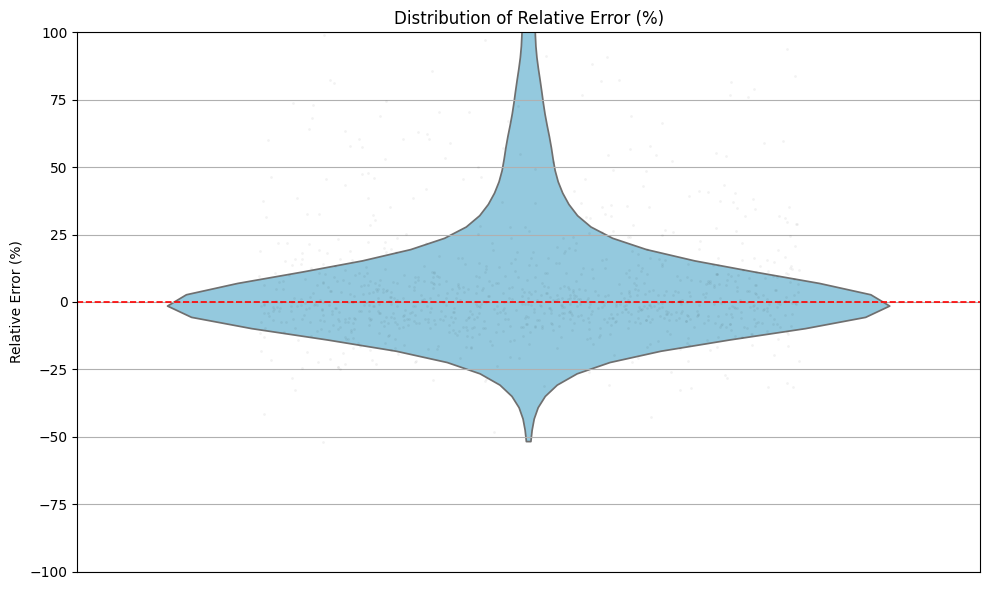

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
sns.violinplot(y=relative_error, inner=None, color='skyblue', cut=0)
sns.stripplot(y=relative_error, color='black', alpha=0.05, jitter=0.3, size=2)

plt.axhline(0, color='red', linestyle='--', linewidth=1.2)
plt.title('Distribution of Relative Error (%)')
plt.ylabel('Relative Error (%)')
plt.grid()
plt.xticks([])
plt.ylim(-100, 100)
plt.tight_layout()
plt.show()


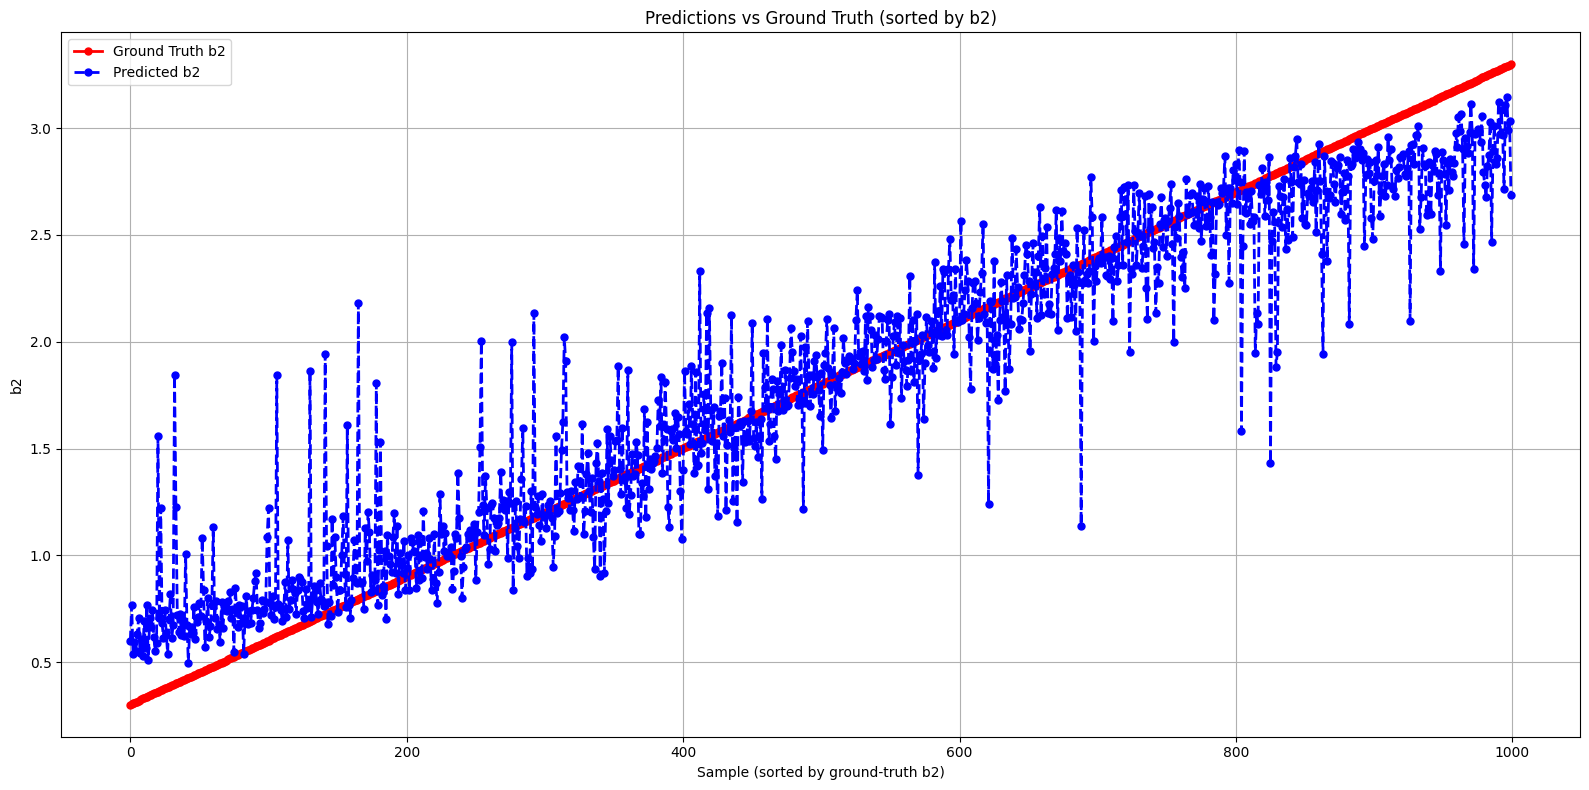

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ── Sort by ground-truth values (ascending) ───────────────────────────────
sorted_idx       = np.argsort(y_test_rescaled)         # indices that sort y_test
y_test_sorted    = y_test_rescaled[sorted_idx]
y_pred_sorted    = y_pred_rescaled[sorted_idx]

# ── Plot both curves with matching order ──────────────────────────────────
plt.figure(figsize=(16, 8))
plt.plot(y_test_sorted, 'r-o',  label=f'Ground Truth {target}', linewidth=2, markersize=5)
plt.plot(y_pred_sorted, 'b--o', label=f'Predicted {target}',   linewidth=2, markersize=5)
plt.xlabel(f'Sample (sorted by ground-truth {target})')
plt.ylabel(f'{target}')
plt.title(f'Predictions vs Ground Truth (sorted by {target})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


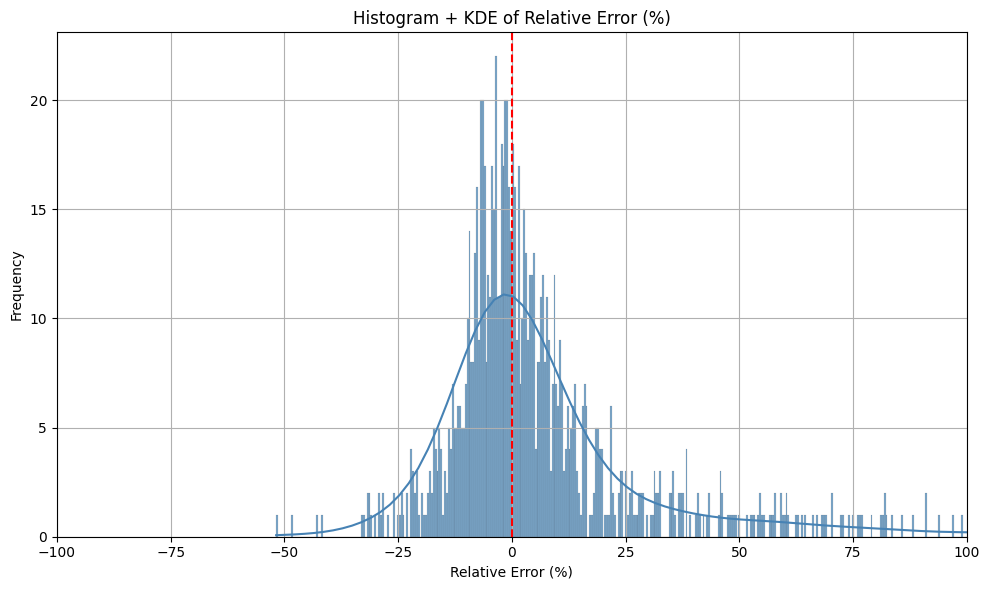

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(relative_error, kde=True, bins=1000, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram + KDE of Relative Error (%)")
plt.xlabel("Relative Error (%)")
plt.ylabel("Frequency")
plt.grid()
plt.xlim(-100, 100)
plt.tight_layout()
plt.show()

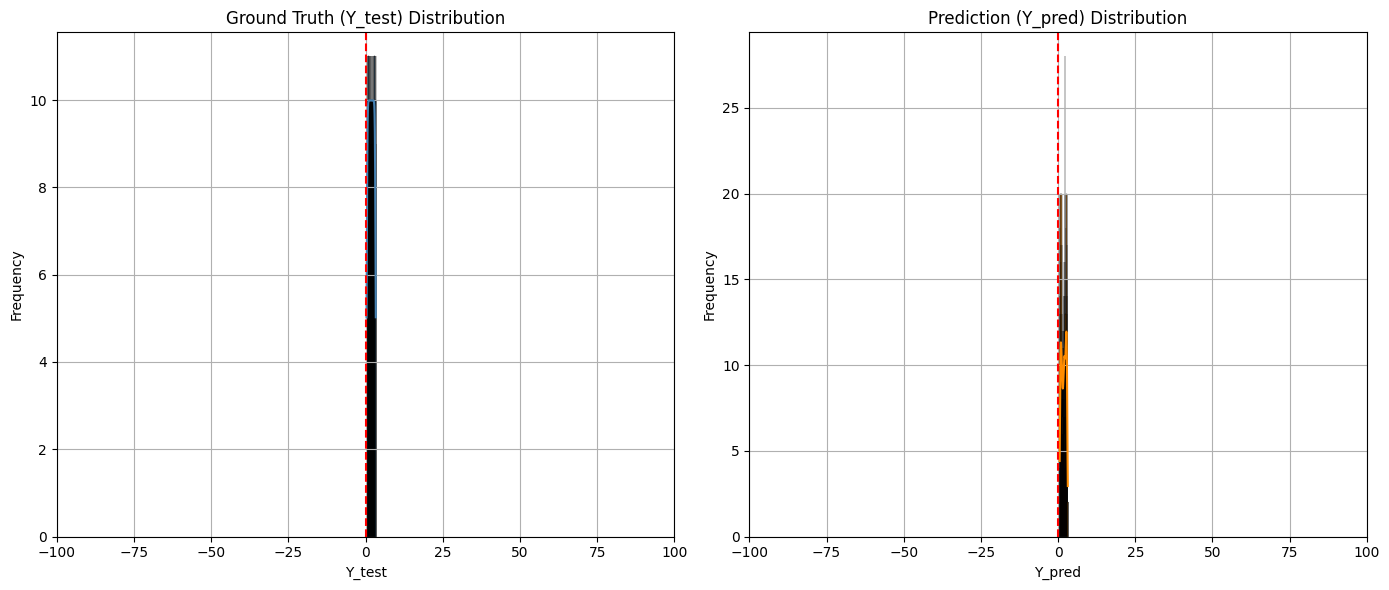

In [26]:
plt.figure(figsize=(14, 6))

# Subplot 1: Ground truth
plt.subplot(1, 2, 1)
sns.histplot(np.asarray(y_test_rescaled).ravel(), kde=True, bins=100, color='steelblue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Ground Truth (Y_test) Distribution")
plt.xlabel("Y_test")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

# Subplot 2: Prediction
plt.subplot(1, 2, 2)
sns.histplot( np.asarray(y_pred_rescaled).ravel(), kde=True, bins=100, color='darkorange', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Prediction (Y_pred) Distribution")
plt.xlabel("Y_pred")
plt.ylabel("Frequency")
plt.grid(True)
plt.xlim(-100, 100)

plt.tight_layout()
plt.show()

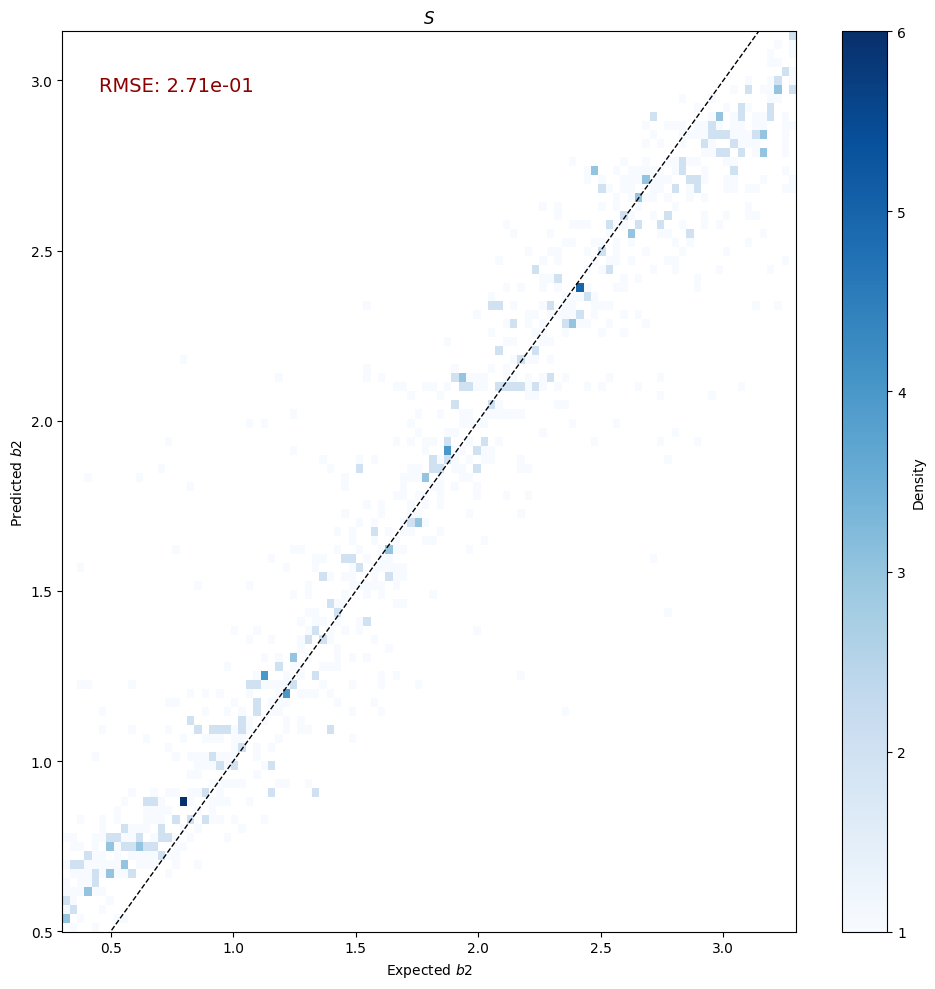

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure y_true and y_pred are 1D numpy arrays
y_true = np.asarray(y_test_rescaled).ravel()
y_pred =np.asarray(y_pred_rescaled).ravel()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Plot
plt.figure(figsize=(10, 10))
plt.hist2d(y_true, y_pred, bins=100, cmap='Blues', cmin=1)

# Plot identity line
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)],
         'k--', lw=1)

# Labels and title
plt.xlabel(f'Expected ${target}$')
plt.ylabel(f'Predicted ${target}$')
plt.title(r'$S$')

# Annotate RMSE
plt.text(0.05, 0.95, f'RMSE: {rmse:.2e}', color='darkred',
         fontsize=14, transform=plt.gca().transAxes, va='top')

plt.colorbar(label='Density')
plt.tight_layout()
plt.show()

In [28]:
# Small epsilon to avoid division by zero
eps = 1e-8

# Relative error (%)
relative_error = (y_pred - y_true) / (y_true + eps) * 100
absolute_relative_error = np.abs(relative_error)

# Compute metrics
mre = np.mean(relative_error)
mape = np.mean(absolute_relative_error)

# Print
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Absolute Percentage Error (MAPE): 16.7133%


In [29]:
lower, upper = np.percentile(relative_error, [16, 84])
print(f"68% CI of HHb₂ % error: {lower:.2f}% to {upper:.2f}%")

68% CI of HHb₂ % error: -9.00% to 21.71%
